# Becca's notebook to check the signal in the GBT-EDGE data cubes

Alberto's directory and results here: https://www.astro.umd.edu/~bolatto/EDGEproblem/

In [1]:
import numpy as np
from astropy.io import fits
import astropy.units as u
from astropy.wcs import WCS
from spectral_cube import SpectralCube
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.size'] = 16

In [2]:
#define some convenience functions
global t_dep
t_dep = 2*u.Gyr

def SFR2Mgas(SFR):
    M_H2 = (t_dep*SFR).to(u.solMass)
    return M_H2

def Mgas2SFR(M_H2):
    SFR = (M_H2/t_dep).to(u.solMass/u.yr)
    return SFR
def beam(bmaj,bmin):
    return np.pi*bmaj*bmin/(4*np.log(2))
def Jybeam2K(I,freq,bmaj,bmin):
    return (1.222E3*I.to(u.mJy/u.beam)/((freq.to(u.GHz)**2)*bmaj.to(u.arcsec)*bmin.to(u.arcsec))).value*u.K
def K2Jybeam(I,freq,bmaj,bmin):
    # I in K
    # freq in GHz
    # bmaj, bmin in arcsec
    return I*freq**2*bmaj*bmin/1.222E6
def beam2pix(I,bmaj,bmin,hdr):
    # I in Jy/beam
    # bmaj, bmin in arcsec
    b = beam(bmaj,bmin)*u.arcsec**2/u.beam
    arcsec2pix = (hdr['CDELT2']*3600)**2*u.arcsec**2/u.pixel
    return I/b*arcsec2pix
def beam2pc2(bmaj,bmin,dist):
    # dist in Mpc
    # bmaj, bmin in arcsec
    b = beam(bmaj,bmin)*u.arcsec**2/u.beam
    b_rad = b/(206265*u.arcsec)**2
    return b_rad*(dist.to(u.pc))**2
    

In [3]:
#grab the galaxy info from the Google Sheet
url = 'https://docs.google.com/spreadsheets/d/1YDy8Go3vfKlgzjNaj1Wh7-8sQcZfqk8rlKr6UFH_rGE'
gid = '1349765067'
df = pd.read_csv(url+'/export?gid='+gid+'&format=csv',skiprows=2,
                 usecols = [0,3,5,11],
                 names=['Name','Redshift','Distance','log(SFR/(Ms/yr))'])

In [4]:
#Load galaxy data
this_gal = 'NGC0001'
#this_gal = 'NGC0169'
#this_gal = 'NGC0776'

idx = df['Name'].values.tolist().index(this_gal)
dist = df['Distance'].values[idx]*u.Mpc
z = df['Redshift'].values[idx]
SFR = (10**df['log(SFR/(Ms/yr))'].values[idx])*u.solMass/u.yr

co_cube = fits.open(this_gal+'_12CO_rebase3_hanning2.fits') #data cube producted by the pipeline
hdr_co_cube = co_cube[0].header
wcs_co_cube = WCS(hdr_co_cube)
co_cube = co_cube[0].data*u.K

Text(0.5, 1.0, 'NGC0001 CO Mom0 no mask')

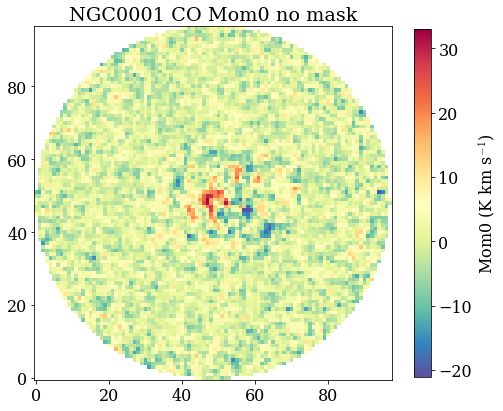

In [5]:
#make a mom0 map WITH NO MASKING TO START
co_mom0_nomask = SpectralCube(data=co_cube,wcs=wcs_co_cube).moment(order=0).to(u.K*u.km/u.s)

plt.figure(1,figsize=(8,8))
plt.imshow(co_mom0_nomask.value,origin='lower',cmap='Spectral_r')
cb=plt.colorbar(shrink=0.8)
cb.set_label('Mom0 (K km s$^{-1}$)')
plt.title(this_gal+' CO Mom0 no mask')

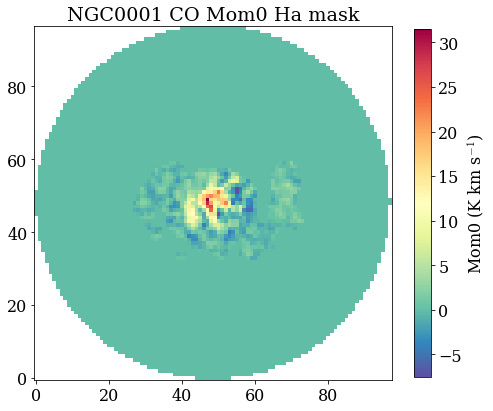

In [6]:
#now apply the Ha mask
mask = fits.open('mask_'+this_gal+'_matched_fixhdr.fits')
hdr_mask = mask[0].header
mask = mask[0].data

co_cube_masked = co_cube*mask
#note: I would have done this all with spectralcube, but it's throwing an error with a mismatch between the headers
co_mom0_masked = SpectralCube(data=co_cube_masked,wcs=wcs_co_cube).moment(order=0).to(u.K*u.km/u.s)

plt.figure(1,figsize=(8,8))
plt.imshow(co_mom0_masked.value,origin='lower',cmap='Spectral_r')
cb=plt.colorbar(shrink=0.8)
cb.set_label('Mom0 (K km s$^{-1}$)')
plt.title(this_gal+' CO Mom0 Ha mask')
plt.savefig(this_gal+'_COmom0_masked.png')

In [7]:
#now convert to molecular gas surface density
X_CO = 2.0E20*(1/(u.cm**2*u.K*u.km/u.s))
alpha_CO = 4.3*u.solMass/(u.pc**2*u.K*u.km/u.s)
freq = hdr_co_cube['RESTFRQ']/1E9
bmaj = hdr_co_cube['BMAJ']*3600
bmin = hdr_co_cube['BMIN']*3600

I_CO = K2Jybeam(co_mom0_masked.value,freq,bmaj,bmin)*u.Jy/u.beam*u.km/u.s
I_CO_nomask = K2Jybeam(co_mom0_nomask.value,freq,bmaj,bmin)*u.Jy/u.beam*u.km/u.s

I_CO_Jypix = beam2pix(I_CO,bmaj,bmin,hdr_co_cube)
I_CO_nomask_Jypix = beam2pix(I_CO_nomask,bmaj,bmin,hdr_co_cube)

I_CO_int_Jykms = np.nansum(I_CO_Jypix*u.pix)
I_CO_nomask_int_Jykms = np.nansum(I_CO_nomask_Jypix*u.pix)

M_mol = 1.05E4*u.solMass*I_CO_int_Jykms/(u.Jy*u.km/u.s)*(dist/u.Mpc)**2/(1+z)
M_mol_nomask = 1.05E4*u.solMass*I_CO_nomask_int_Jykms/(u.Jy*u.km/u.s)*(dist/u.Mpc)**2/(1+z)

#convert this to a SFR assuming tdep = 2 Gyr
sfr = Mgas2SFR(M_mol/1.36)
sfr_nomask = Mgas2SFR(M_mol_nomask/1.36)

In [8]:
#what MH2 would we get based on the measured SFR and tdep=2Gyr?
M_H2_fromSFR = SFR2Mgas(SFR)
Mmol_fromSFR = 1.36*M_H2_fromSFR

In [9]:
#compare the measured and predicted SFRs and Mgas

print(this_gal)

print('\t\t\t\t Measured \t Predicted')
print('log10(Mmol [Msun]) = \t\t %.2f \t\t %.2f' %(np.log10(M_mol.value),np.log10(Mmol_fromSFR.value)))
print('SFR [Msun/yr] = \t\t %.1f \t\t %.1f' %(SFR.value,sfr.value))

print('\nMeasured Mmol from GBT CO obs. Measured SFR from Halpha.')
print('Predicted Mmol from SFR_Halpha, assuming tdep = %.1f Gyr. Predicted SFR from Mmol_CO.' %t_dep.value)


NGC0001
				 Measured 	 Predicted
log10(Mmol [Msun]) = 		 9.14 		 10.08
SFR [Msun/yr] = 		 4.5 		 0.5

Measured Mmol from GBT CO obs. Measured SFR from Halpha.
Predicted Mmol from SFR_Halpha, assuming tdep = 2.0 Gyr. Predicted SFR from Mmol_CO.


In [10]:
print(this_gal+' No Mask')

print('\t\t\t\t Measured \t Predicted')
print('log10(Mmol [Msun]) = \t\t %.2f \t\t %.2f' %(np.log10(M_mol_nomask.value),np.log10(Mmol_fromSFR.value)))
print('SFR [Msun/yr] = \t\t %.1f \t\t %.1f' %(SFR.value,sfr_nomask.value))

print('\nMeasured Mmol from GBT CO obs w/o mask. Measured SFR from Halpha.')
print('Predicted Mmol from SFR_Halpha, assuming tdep = %.1f Gyr. Predicted SFR from Mmol_CO_nomask.' %t_dep.value)


NGC0001 No Mask
				 Measured 	 Predicted
log10(Mmol [Msun]) = 		 9.18 		 10.08
SFR [Msun/yr] = 		 4.5 		 0.6

Measured Mmol from GBT CO obs w/o mask. Measured SFR from Halpha.
Predicted Mmol from SFR_Halpha, assuming tdep = 2.0 Gyr. Predicted SFR from Mmol_CO_nomask.


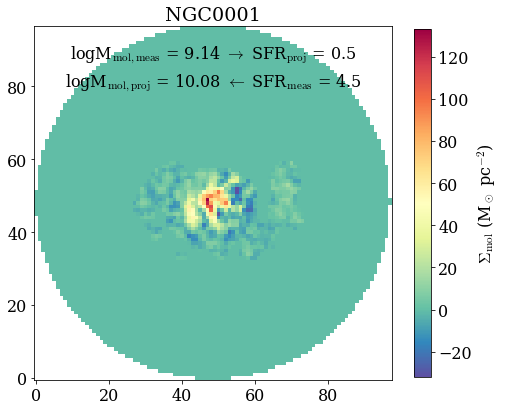

In [11]:
#also calc and plot Sigma mol
I_CO_Jypc2 = I_CO/beam2pc2(bmaj,bmin,dist)
Sigma_mol_Msunpc2 = 1.05E4*u.solMass*I_CO_Jypc2/(u.Jy*u.km/u.s)*(dist/u.Mpc)**2/(1+z)

plt.figure(1,figsize=(8,8))
plt.imshow(Sigma_mol_Msunpc2.value,origin='lower',cmap='Spectral_r')
cb=plt.colorbar(shrink=0.8)
cb.set_label('$\Sigma_{\mathrm{mol}}$ (M$_\odot$ pc$^{-2}$)')
plt.title(this_gal)
plt.text(0.5,0.95,r'logM$_{\mathrm{mol,meas}}$ = %.2f $\rightarrow$ SFR$_{\mathrm{proj}}$ = %.1f' %(np.log10(M_mol.value),sfr.value),
        transform=plt.gca().transAxes,ha='center',va='top')
plt.text(0.5,0.87,r'logM$_{\mathrm{mol,proj}}$ = %.2f $\leftarrow$ SFR$_{\mathrm{meas}}$ = %.1f' %(np.log10(Mmol_fromSFR.value),SFR.value),
        transform=plt.gca().transAxes,ha='center',va='top')
plt.savefig(this_gal+'_Sigmamol_masked.png')


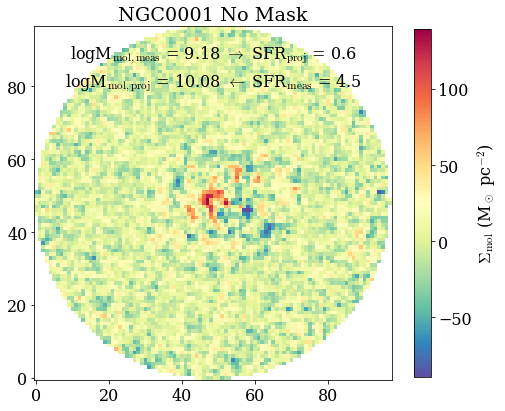

In [12]:
#also calc and plot Sigma mol
I_CO_nomask_Jypc2 = I_CO_nomask/beam2pc2(bmaj,bmin,dist)
Sigma_mol_nomask_Msunpc2 = 1.05E4*u.solMass*I_CO_nomask_Jypc2/(u.Jy*u.km/u.s)*(dist/u.Mpc)**2/(1+z)

plt.figure(1,figsize=(8,8))
plt.imshow(Sigma_mol_nomask_Msunpc2.value,origin='lower',cmap='Spectral_r')
cb=plt.colorbar(shrink=0.8)
cb.set_label('$\Sigma_{\mathrm{mol}}$ (M$_\odot$ pc$^{-2}$)')
plt.title(this_gal+' No Mask')
plt.text(0.5,0.95,r'logM$_{\mathrm{mol,meas}}$ = %.2f $\rightarrow$ SFR$_{\mathrm{proj}}$ = %.1f' %(np.log10(M_mol_nomask.value),sfr_nomask.value),
        transform=plt.gca().transAxes,ha='center',va='top')
plt.text(0.5,0.87,r'logM$_{\mathrm{mol,proj}}$ = %.2f $\leftarrow$ SFR$_{\mathrm{meas}}$ = %.1f' %(np.log10(Mmol_fromSFR.value),SFR.value),
        transform=plt.gca().transAxes,ha='center',va='top')
plt.savefig(this_gal+'_Sigmamol_nomask.png')
